# Titanic - Machine Learning from Disaster 

## About Dataset

<img src="https://imgur.com/rE1OxtK.jpg">

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

The goal in this project is to use the Titanic passenger data (name, age, gender, socio-economic class, etc) to predict weather or not passenger survived.

## Data Source

The dataset has been referred from Kaggle and it can be downloaded [here](https://www.kaggle.com/c/titanic/data).

## Data Exploration 

In [2]:
import pandas as pd

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


There are 12 attributes as follows:
- PassengerId -> a unique identifier for each passenger
- Survived -> target attribute, 0 means the passenger did not survive and 1 means he/she survived
- Pclass -> ticket class (upper, middle, lower)
- Name -> name of the passenger
- Sex -> passenger gender
- Age -> passneger age in years
- SibSp -> number of siblings and spouses of the passenger aboard the Titanic (sibling = brother, sister, stepbrother, stepsister; spouse = husband, wife (mistresses and fiancés were ignored))
- Parch -> number of parents and children of the passenger aboard the Titanic (parent = mother, father; child = daughter, son, stepdaughter, stepson; some children travelled only with a nanny, therefore parch=0 for them.)
- Ticket -> ticket number
- Fare -> passenger's fare pain in pounds
- Cabin -> 	passenger's cabin number
- Embarked -> where the passenger embarked the Titanic (C = Cherbourg, Q = Queenstown, S = Southampton)

In [5]:
# Set PassengerId as index column
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [8]:
# Check if some data is missing
train_data.isna().values.any()

True

In [9]:
train_data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

The Age, Cabin, and Embarked attributes have missing values. 77% of values are missing for the Cabin attribute. About 20% of Age attribute is missing and it would be reasonable to replace them with median value. Embarked attribute is missing 2 values.

In [10]:
# Check for duplicates
train_data.duplicated().values.any()

False

There are no duplicates in the train_data.

In [11]:
# Look at descriptive statistics
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
# Look at the target data
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [13]:
# Look at the categorical variables like Pclass, Sex, Embarked
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [14]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [15]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

## Data Preparation and Cleaning

In [16]:
# Build preprocessing pipeline for numerical attributes
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [20]:
# Build preprocessing pipeline for categorical attributes
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

In [21]:
# Join the numerical and categorical pipelines
from sklearn.compose import ColumnTransformer

num_attributes = ["Age", "SibSp", "Parch", "Fare"]
cat_attributes = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", cat_pipeline, cat_attributes)
])

In [22]:
X_train = preprocess_pipeline.fit_transform(train_data[num_attributes + cat_attributes])
X_train

C:\Users\ttomk\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [23]:
# Get the labels
y_train = train_data["Survived"]

## Random Forest Classification

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [25]:
# Preprocess test data for prediction
X_test = preprocess_pipeline.transform(test_data[num_attributes + cat_attributes])
y_pred = forest_clf.predict(X_test)

In [26]:
# Check cross-validation to get an idea of how good the model is
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

## Support Vector Machine

In [27]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

SVC model looks better than Random Forest

## Compare SVM and Random Forest Models

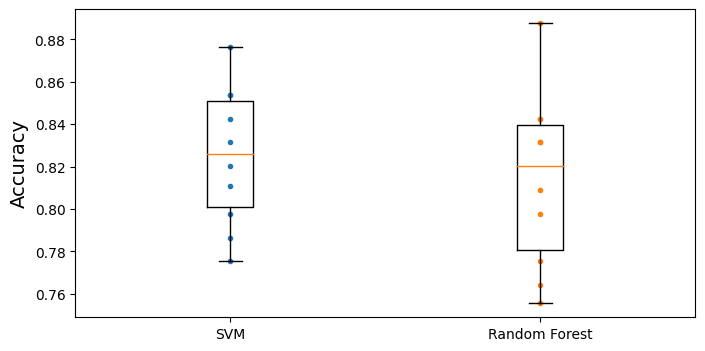

In [28]:
# Plot 10 scores for each model using Box plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

The random forest classifier has lower mean score and bigger spread than SVM and therefore, SVM classifies better.

Results can be improved by comparing more models and fine tunning hyperparameters using cross validation and grid search.
Another way is doing feature engineering like grouping age into buckets and use it instead of Age attribute, since different age groups had different survival rate. Also, combining SibSp and Parch into one attribute.